# Biol 359A  | Data as matrices, ANOVA
### Spring 2022, Week 3
<hr>

Objectives:
-  Understand the structure of data
-  Gain intuition about ANOVA
-  Read some more basic python syntax

Updates from last classwork:
-  Now that you have had time to familiarize yourselves with the interface, we will be grading some components on __both__ accuracy and engagement! 

# W2 Quiz Review

Question 1: 
Example of an associated variable that is neither causal nor correlated: Time and tides. Often modeled with sin curves! 

Question 7:

- The P-value is the false positive rate of a statistical test.
  - fix: The __alpha error__ is the false positive rate of a statistical test.
- _The P-value is also known as the significance level of a test._
  - fix: The __alpha__ is also known as the significance level of a test. 
- The P-value must be less than 5% to reject a hypothesis. 
  - fix: The P-value must less than the __alpha__/__significance level__ to reject a (null) hypothesis.
- __The P-value is the probability of observing the sample or a more extreme value.__


Question 8:
- __The beta error depends on the properties of the alternative distribution.__
- __The alpha error determines the threshold beyond which samples motivate rejection of the null hypothesis.__
- _The power of a statistic depends on both the alpha and the beta error._
  - __This statement could be argued as true or false__, so we have given everyone credit for this answer. 
- _The alpha error is anchored to observed samples._
  - The alpha error is defined __before__ observing samples.

## How to read an ANOVA table

![anova](anovatable.png)

- `sum_sq`: Sum of Squares
- `df`: Degrees of freedom (n-1)
- `F`: F-statistic
- `PR(>F)`: p-value

# Classwork:

reminder: Make sure you run __every__ cell using `shift`+`enter` or pressing the play button the left side of every cell. 

In [ ]:
!git clone https://github.com/BIOL359A-FoundationsOfQBio-Spr22/week3_anova
!mkdir ./data
!cp week3_anova/data/* ./data

In [14]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import random
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import ttest_ind as ttest

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot

TITLE_FONT = 20
LABEL_FONT = 16
TICK_FONT = 16
FIG_SIZE = (12,12)

sns.set_context("notebook")
sns.set_style("whitegrid")
sns.set(font_scale=1) #Change from 1 to 1.5 or 2 if you have a hard time reading text

# Questions 2-3: Sample size and Power

There are a number of factors that go into statistical test design. 
Sample sizes and alpha are very important to the power (our ability to reject the null hypothesis) of significance tests. 
Remember, Power is bounded between $1 - P(\text{False Negative})$, or $1-\beta$. 
The other component of power is the actual __effect size__ (ratio of the difference in means divided by the standard deviation) that we want to be able __consistently__ label as significant. 
As quantitative biologists, we must be aware of how all of these components effect one another. 
Consider the following experiment, and answer the questions in the quiz:


In [15]:
def run_experiment(effect_size = 0.1, n=1000):
    mu_A = 0
    sigma = 2
    
    mu_B = sigma*effect_size+mu_A
    A = [random.gauss(mu_A, sigma) for _ in range(n)]
    B = [random.gauss(mu_B, sigma) for _ in range(n)]
    return A, B

@widgets.interact_manual(effect_size=(0.0,1.0), n=[3,10,30,100])
def run_ttest(effect_size, n):
    A,B = run_experiment(effect_size)
    pvalues=[]
    for i in range(0,200):
        tstat, pvalue = ttest(np.random.choice(A, size=n), np.random.choice(B, size=n))
        pvalues.append(pvalue)
    p_arr = np.array(pvalues)
    power = 1 - np.count_nonzero((p_arr > 0.05))/p_arr.size
    print(f"Power: {power}")
    sns.histplot(pvalues, stat="probability", kde="true")
    plt.title(f"Histogram of p-values, sample size = {n}")
    

interactive(children=(FloatSlider(value=0.5, description='effect_size', max=1.0), Dropdown(description='n', op…

# Question 4: Multiple tests

Data source: https://reneshbedre.github.io/assets/posts/anova/twowayanova.txt

This data is not real data, so we will not be focusing on interpreting the biological results here.

### Dataset

In [16]:
basic_df = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/twowayanova.txt", sep="\t")
basic_df.columns = ["Genotype", "Year1", "Year2", "Year3"]
subsample_genotypes = ["A","B","C","D"]
subsample = pd.concat([x for g,x in basic_df.groupby("Genotype") if g in ["A","B","C","D"]])
subsample

,Genotype,Year1,Year2,Year3
0,A,1.53,4.08,6.69
1,A,1.83,3.84,5.97
2,A,1.38,3.96,6.33
3,B,3.60,5.70,8.55
4,B,2.94,5.07,7.95
5,B,4.02,7.20,8.94
6,C,3.99,6.09,10.02
7,C,3.30,5.88,9.63
8,C,4.41,6.51,10.38
9,D,3.75,5.19,11.40


### Combinatorial _t_-test

We have a higher chance of seeing a false positive when we run multiple tests! 
If you ran the test for 0.0 effect size, the p-value is uniformly distributed between 0 and 1, which is expected.
That means with an alpha of 0.05, we would say 5% of our tests are significant even though we have no effect!
Remember, alpha is our False Negative rate as well. 
The most common (and most strict) correction that we can do is divide our original $\alpha$ by the number of tests that we run, which is called the Bonferroni correction. 
Remember that decreasing our $\alpha$, increases our $\beta$, abd therefore decreases our power. 
We shall explore that more in the experiment below:

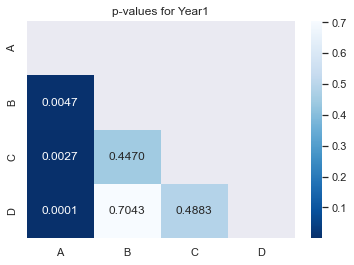

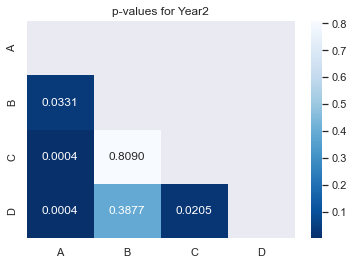

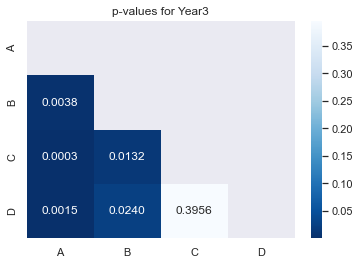

In [17]:
def combinations(year="Year1"):
    pvalues = np.zeros(shape=(4,4))
    i=0
    for genotype, genotype_df in subsample.groupby("Genotype"):
        for j, other_geno in enumerate(subsample_genotypes):
            other = subsample[subsample["Genotype"] == other_geno]
            tstat, pvalue = ttest(genotype_df[year], other[year])
            pvalues[i][j] = pvalue
        i += 1
        
    mask = np.triu(np.ones_like(pvalues, dtype=bool))
    sns.heatmap(pvalues, mask=mask, cmap="Blues_r", annot=True, fmt="0.4f", 
                xticklabels=subsample_genotypes,
                yticklabels=subsample_genotypes)
    plt.title(f"p-values for {year}")
    plt.show()
    return pvalues

array_list = []
for year in ["Year1", "Year2", "Year3"]:
    array_list.append(combinations(year))
    

# Question 5-7: ANOVA

ANOVA, discussed on Monday, is one way that we can compare all the means between groups, so that we can reduce it to one test instead of every combination of _t_-test! 
You will see that the dataset was actually shorted for the purposes of the last exercise, but there are in fact 6 groups rather than 4 (which greatly increases the number of tests).

Let's dive into ANOVA, but first we will view the entire dataset.

In [5]:
basic_df

,Genotype,Year1,Year2,Year3
0,A,1.53,4.08,6.69
1,A,1.83,3.84,5.97
2,A,1.38,3.96,6.33
3,B,3.60,5.70,8.55
4,B,2.94,5.07,7.95
5,B,4.02,7.20,8.94
6,C,3.99,6.09,10.02
7,C,3.30,5.88,9.63
8,C,4.41,6.51,10.38
9,D,3.75,5.19,11.40


### One-way ANOVA

In [6]:
def perform_oneway_anova(df, independent = "Genotype", dependent = "Year1"):
    model = ols(f'{dependent} ~ C({independent})', data=df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    sns.boxplot(data=df, y=dependent, x=independent)
    return aov_table
    
@widgets.interact(dependent=["Year1", "Year2", "Year3"])
def anova_by_year(dependent):
    return perform_oneway_anova(basic_df, independent="Genotype", dependent = dependent)
    

interactive(children=(Dropdown(description='dependent', options=('Year1', 'Year2', 'Year3'), value='Year1'), O…

What if there is a second category that we care about, like the year? 
We can use two-way ANOVA to try to capture this additional layer of complexity. 
There are a couple different ways of calculating this, but it is possible to account for the __interaction__ of two variables by also using the _covariance_ as one of the variables. 
We will cover this in more detail in the future! 

### Two-way ANOVA

In [7]:
def perform_twoway_anova(df, interaction=False, ind = ["Genotype", "years"], dep = "value"):
    d_melt = pd.melt(df, id_vars=['Genotype'], value_vars=['Year1', 'Year2', 'Year3'])
    d_melt.columns = ['Genotype', 'years', 'value']
    
    if interaction: 
        model = ols(f'{dep} ~ C({ind[0]}) + C({ind[1]}) + C({ind[0]}):C({ind[1]})', data=d_melt).fit()
    else: 
        model = ols(f'{dep} ~ C({ind[0]}) + C({ind[1]})', data=d_melt).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    return aov_table

@widgets.interact(interaction=[False,True])
def ineractions_twoway_anova(interaction):
    return perform_twoway_anova(basic_df, interaction)

interactive(children=(Dropdown(description='interaction', options=(False, True), value=False), Output()), _dom…

# Question 8: How do we represent data

Why does the __structure__ of data matter? 
There is a lot of math that is important to calculating statistics. 
There is not a lot we can do with words, so we need to represent them as numbers. 

There are several different types of variables that contain valuable information: 
-  Categorical: Variables than can be placed into bins (something like species, or diseases)
-  Ordinal: Ordered categorical variables (think stages of a disease)
-  Binary (boolean): True/False (Any categorical variable can be written as multiple binary variables)
-  Continuous: All real numbers (can be bounded)
-  Discrete: Limited selection of distinct numbers 



We skipped a step that was important to the two-way ANOVA. We formatted our data as follows:


### Original data

In [8]:
basic_df

,Genotype,Year1,Year2,Year3
0,A,1.53,4.08,6.69
1,A,1.83,3.84,5.97
2,A,1.38,3.96,6.33
3,B,3.60,5.70,8.55
4,B,2.94,5.07,7.95
5,B,4.02,7.20,8.94
6,C,3.99,6.09,10.02
7,C,3.30,5.88,9.63
8,C,4.41,6.51,10.38
9,D,3.75,5.19,11.40


### Reformatted data

Notice that we aren't losing any information by reshaping the data.
We are still able to capture the behavior of years, but we also now have more observations to compare Genotype with. 
This restructuring causes the _p_-values to be lower in the two-way ANOVA.

In [9]:
d_melt = pd.melt(basic_df, id_vars=['Genotype'], value_vars=['Year1', 'Year2', 'Year3'])
d_melt.columns = ['Genotype', 'years', 'value']
d_melt

,Genotype,years,value
0,A,Year1,1.53
1,A,Year1,1.83
2,A,Year1,1.38
3,B,Year1,3.60
4,B,Year1,2.94
5,B,Year1,4.02
6,C,Year1,3.99
7,C,Year1,3.30
8,C,Year1,4.41
9,D,Year1,3.75


We also commonly represent data as a matrix, which is useful for a lot of mathematical operations that we may want to do, which we will discuss more in the future. 
Whenever we show you tables, we can generally refer to that as a matrix.
However, as we just showed, rows and columns aren't intrinsic components of data. 

We (and the internet) will generally refer to dependent variables as __responses__ (continuous) or __labels__ (categorical), independent variables as __features__, and individual samples as __observations__. 
These are generally used as terms to describe models, but can be useful when discussing the structure of data as well.

![annotated_data](annotated_data.png)

With a couple of definitions out of the way, let us look at the structure of some blood test data:

In [11]:

def clean_lab_data(n=12):
    lab_data = pd.read_csv("data/hcvdat0.csv", index_col=0)
    lab_data = lab_data[lab_data["Category"] != "0s=suspect Blood Donor"]
    lab_data = lab_data.dropna(axis=0)
    df_list = []
    for category, category_df in lab_data.groupby("Category"):
        df_list.append(category_df.sample(n, random_state=5))
    
    return pd.concat(df_list)
        

lab_data = clean_lab_data()
print(lab_data.shape)
lab_data

(48, 13)


,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
424,0=Blood Donor,47,f,40.3,65.0,13.5,15.2,6.4,7.16,4.55,70.0,16.5,66.2
531,0=Blood Donor,65,f,33.0,74.3,13.2,16.8,4.1,7.46,5.76,52.0,9.1,64.2
362,0=Blood Donor,38,f,50.3,92.1,40.1,30.9,4.2,10.02,3.97,100.0,30.5,77.3
422,0=Blood Donor,47,f,36.4,42.0,11.1,18.3,7.2,4.97,5.47,74.0,7.9,67.0
361,0=Blood Donor,38,f,48.5,56.2,36.0,27.9,15.3,11.07,6.06,69.0,23.5,77.3
347,0=Blood Donor,35,f,62.9,51.2,20.7,23.0,2.9,6.33,4.62,67.0,15.2,71.9
275,0=Blood Donor,59,m,37.8,83.7,25.3,20.0,18.6,7.52,5.07,108.0,17.4,64.1
354,0=Blood Donor,36,f,39.7,52.0,39.9,33.5,2.9,9.00,4.18,77.0,27.0,78.5
308,0=Blood Donor,67,m,44.8,72.8,39.4,28.4,23.3,7.84,7.02,97.0,78.3,67.5
532,0=Blood Donor,68,f,41.4,102.3,38.4,26.4,6.8,8.50,6.79,59.0,23.8,68.9


- albumin (ALB)

- alkaline phosphatase (ALP)

- alanine amino-transferase (ALT)

- aspartate amino-transferase (AST)

- bilirubin (BIL) 

- choline esterase (CHE)

- cholesterol (CHOL)

- creatinine (CREA)* 

- γ-glutamyl-transferase (GGT)

- total protein (PROT)*

\* I think, the dataset was not very well annotated.

Source: https://archive.ics.uci.edu/ml/datasets/HCV+data#

We have gone through and cleaned out some of the data that was incomplete, and also reduced the samples to be the same across all groups. 

# Question 7-8: ANOVA assumptions

We have mentioned the idea of a "normality" assumption multiple times through this class, and there are statistical tests that help test for normality. 
However, those tests are a little more complicated, but one option is using QQ-plots or Quantile-Quantile plots to assess how well the data matches with a distribution. 
It is a plot comparing the probability of the sample occruing in the data, and the probability that the sample occurs in a normal distribution.
If it falls on the line, it is safe to treat it as normal. 

![qqplots](qqplot.png)

__Aside__: As a result of the CLT, ANOVA, similarly to t-tests, is generally robust to departures from normality and differences in variance, but at large sample sizes. If you have a small sample size, the ANOVA is no longer robust to departures from the assumptions made when designing the test.

In [ ]:
@widgets.interact(feature = ["ALB", "ALP", "ALT", "AST", "BIL", "CHE", "CHOL", "CREA", "GGT", "PROT"])
def show_hist_gg_plots(feature = "ALB"):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
    sns.histplot(data=lab_data, x=feature, hue="Category", stat="probability", kde=True, ax=ax1)
    qqplot(lab_data[feature].dropna(), norm, fit=True, line="45", ax=ax2)
    plt.show()
    return perform_oneway_anova(lab_data, independent = "Category", dependent = feature)


### Optional: Looking forward to linear models

There is another common way of thinking about ANOVA: a linear model where the means ($\bar{X}_i = \hat{\beta}_i$ of a group are the best prediction of any individual group value.
Remember that any categorical variable can be written as a series of binary variables. 
This transformation is called "One-hot encoding". 
Let's say that we have 3 groups, we can rewrite this as 3 binary features: $x_a$, $x_b$, $x_c$ that indicate what group a observation belongs to. 
If we rewrite categorical variables in this way, we can use a mathematical formula to capture the behavior of the groups to predict some response $y$:

$$ y = \hat{\beta}_a x_a + \hat{\beta}_b x_b + \hat{\beta}_c x_c $$

This result is the solution to the __least squares__ problem, which is also how we will solve the linear regression problem.
This model (using __error__ or the __residuals__) is then compared to comparing to simply using the average of all the groups to predict $y$. 
This notation will start to look much more familiar starting next week. 
